In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow
import glob
import os
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['[1]Sitting-on-Bed',
          '[2]Sitting-on-Chair',
          '[3]Lying-Down',
          '[4]Ambulating']
# The number of steps within one time segment
TIME_PERIODS = 100
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 10

keras version  2.2.4


In [3]:
def read_data(file_path):
    
    pd.options.display.float_format = '{:,.4f}'.format

    column_names = ['experiment-id',
                    'time',
                    'frontal-acceleration',
                    'vertical-acceleration',
                    'lateral-acceleration',
                    'antenna-id',
                    'RSSI',
                    'phase',
                    'frequency',
                    'label']
    
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)

    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [4]:
# Load data set containing all the data

df = read_data('/Users/Mariana/Desktop/test_file.txt')

#Reading multiple files not working **--**
#file_path = '/Users/Mariana/Desktop/S1_Dataset/'
#read_files = glob.glob(os.path.join(file_path, '*.txt'))
#np_array_values = []

#for files in read_files:

#    df = pd.read_csv(files, header=None, names=column_names)
    
#    df.dropna(axis=0, how='any', inplace=True)

#    np_array_values.append(df)


In [5]:
# Describe the data
show_basic_dataframe_info(df)
df.head(20)


Number of columns in the dataframe: 10
Number of rows in the dataframe: 52482



,experiment-id,time,frontal-acceleration,vertical-acceleration,lateral-acceleration,antenna-id,RSSI,phase,frequency,label
0,1,0.0000,0.2720,1.0082,-0.0821,1,-63.5000,2.4252,924.2500,1
1,1,0.5000,0.2720,1.0082,-0.0821,1,-63.0000,4.7369,921.7500,1
2,1,1.5000,0.4479,0.9164,-0.0137,1,-63.5000,3.0311,923.7500,1
3,1,1.7500,0.4479,0.9164,-0.0137,1,-63.0000,2.0371,921.2500,1
4,1,2.5000,0.3424,0.9623,-0.0593,1,-63.5000,5.8920,920.2500,1
5,1,3.2500,0.3424,0.9623,-0.0593,4,-56.5000,1.2563,924.7500,1
6,1,4.0000,0.3072,0.9967,-0.0707,1,-63.5000,3.8718,922.7500,1
7,1,5.0000,0.2720,0.9967,-0.0935,1,-64.0000,2.4943,924.2500,1
8,1,5.5000,0.2369,1.0312,-0.1277,1,-64.5000,2.0080,924.7500,1
9,1,6.0000,0.2369,1.0312,-0.1277,1,-66.0000,1.1904,925.7500,1


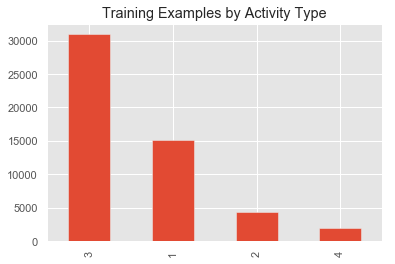

[1]Sitting-on-Bed
[2]Sitting-on-Chair
[3]Lying-Down
[4]Ambulating


In [6]:
df['label'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')

plt.show()

for i in LABELS:
    print(i)

# Split Data into Training and Test Set


In [7]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = df['label'].values.ravel()

In [8]:
# Differentiate between test set and training set
df_test = df[df['experiment-id'] > 50]
df_train = df[df['experiment-id'] <= 50]

## Normalize Training Data

In [19]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 6 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['frontal-acceleration'] = df_train['frontal-acceleration'] / df_train['frontal-acceleration'].max()
df_train['vertical-acceleration'] = df_train['vertical-acceleration'] / df_train['vertical-acceleration'].max()
df_train['lateral-acceleration'] = df_train['lateral-acceleration'] / df_train['lateral-acceleration'].max()
df_train['RSSI'] = df_train['RSSI'] / df_train['RSSI'].max()
df_train['phase'] = df_train['phase'] / df_train['phase'].max()
df_train['frequency'] = df_train['frequency'] / df_train['frequency'].max()

# Round numbers
df_train = df_train.round({'frontal-acceleration': 4,
                           'vertical-acceleration': 4,
                           'lateral-acceleration': 4,
                           'RSSI': 4,
                           'phase': 4,
                           'frequency': 4})

## Reshape Data into Segments and Prepare for Keras


In [20]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 6
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        fa = df['frontal-acceleration'].values[i: i + time_steps]
        va = df['vertical-acceleration'].values[i: i + time_steps]
        la = df['lateral-acceleration'].values[i: i + time_steps]
        rs = df['RSSI'].values[i: i + time_steps]
        ph = df['phase'].values[i: i + time_steps]
        fr = df['frequency'].values[i: i + time_steps]

        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([fa, va, la, rs, ph, fr])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

LABEL = 'label'
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [21]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (3926, 100, 6)
3926 training samples
y_train shape:  (3926,)


In [22]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]

num_classes = 5

In [23]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (3926, 600)
input_shape: 600


In [24]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [25]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (3926, 5)


## Create Deep Neural Network Model in Keras

In [26]:
model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((TIME_PERIODS, 6), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 100, 6)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 100, 100)          700       
_________________________________________________________________
dense_6 (Dense)              (None, 100, 100)          10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100, 100)          10100     
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 50005     
Total params: 70,905
Trainable params: 70,905
Non-trainable params: 0
_________________________________________________________________
None


## Fit the DNN Model in Keras

In [40]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 3140 samples, validate on 786 samples
Epoch 1/50
3140/3140 [==============================] - 3s 930us/step - loss: 0.1690 - acc: 0.9328 - val_loss: 0.3360 - val_acc: 0.8715
Epoch 2/50
3140/3140 [==============================] - 2s 554us/step - loss: 0.1065 - acc: 0.9627 - val_loss: 0.4238 - val_acc: 0.8893
Epoch 3/50
3140/3140 [==============================] - 2s 551us/step - loss: 0.0902 - acc: 0.9666 - val_loss: 0.3327 - val_acc: 0.8893
Epoch 4/50
3140/3140 [==============================] - 2s 549us/step - loss: 0.0743 - acc: 0.9796 - val_loss: 0.3944 - val_acc: 0.8969
Epoch 5/50
3140/3140 [==============================] - 2s 626us/step - loss: 0.0662 - acc: 0.9815 - val_loss: 0.3882 - val_acc: 0.8995
Epoch 6/50
3140/3140 [==============================] - 2s 681us/step - loss: 0.0641 - acc: 0.9815 - val_loss: 0.3775 - val_acc: 0.8969


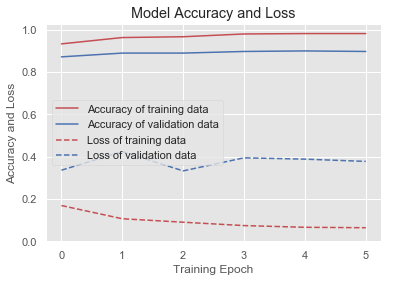

              precision    recall  f1-score   support

         1.0       0.93      0.96      0.95      1066
         2.0       0.88      0.88      0.88       361
         3.0       1.00      0.99      1.00      2421
         4.0       0.91      0.63      0.74        78

   micro avg       0.97      0.97      0.97      3926
   macro avg       0.93      0.87      0.89      3926
weighted avg       0.97      0.97      0.97      3926



In [41]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [42]:
# Normalize features for training data set
df_test['frontal-acceleration'] = df_test['frontal-acceleration'] / df_test['frontal-acceleration'].max()
df_test['vertical-acceleration'] = df_test['vertical-acceleration'] / df_test['vertical-acceleration'].max()
df_test['lateral-acceleration'] = df_test['lateral-acceleration'] / df_test['lateral-acceleration'].max()
df_test['RSSI'] = df_test['RSSI'] / df_test['RSSI'].max()
df_test['phase'] = df_test['phase'] / df_test['phase'].max()
df_test['frequency'] = df_test['frequency'] / df_test['frequency'].max()

df_test = df_test.round({'frontal-acceleration': 4, 'vertical-acceleration': 4, 'lateral-acceleration': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

1303/1303 [==============================] - 0s 203us/step

Accuracy on test data: 0.87

Loss on test data: 0.44


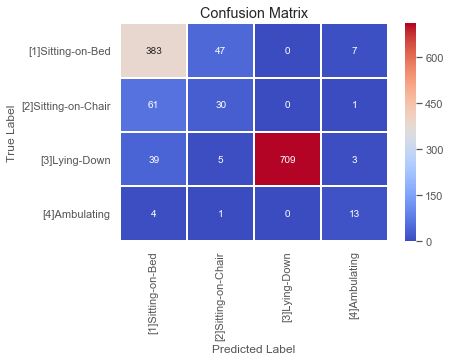

              precision    recall  f1-score   support

           1       0.79      0.88      0.83       437
           2       0.36      0.33      0.34        92
           3       1.00      0.94      0.97       756
           4       0.54      0.72      0.62        18

   micro avg       0.87      0.87      0.87      1303
   macro avg       0.67      0.72      0.69      1303
weighted avg       0.88      0.87      0.87      1303



In [43]:

def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))